In [45]:
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import sys
from collections import Counter
import pandas as pd
from skimage import segmentation
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
path_train = "../Data/dataset DRIVE/training/images/"
training_images = os.listdir(path_train)
train_images = {}
for i in sorted(training_images):
    number = i[0:2]
    img = np.array(PIL.Image.open(f'{path_train}{i}').convert("RGB"))
    train_images[str(number)] =  img

In [3]:
path_labels = "../Data/dataset DRIVE/training/1st_manual/"
training_labels = os.listdir(path_labels)
labels = {}
for image in training_labels:
    img = np.array(PIL.Image.open(f'{path_labels}{image}').convert("L"), dtype=np.float32)
    labels[image[0:2]] = img

In [4]:
path_maks = "../Data/dataset DRIVE/training/mask/"
training_masks = os.listdir(path_maks)
masks = {}
for image in training_masks:
    img = np.array(PIL.Image.open(f'{path_maks}{image}').convert("RGB"), dtype=np.float32)
    masks[image[0:2]] = img

In [5]:
#Multiplico las imágenes elemento a elemento por sus máscaras
for i in masks.keys():
    train_images[i] = train_images[i] * masks[i]/255

# Kmeans

In [6]:
from sklearn.cluster import KMeans, DBSCAN

In [7]:
image = train_images['21'].reshape(-1,3)

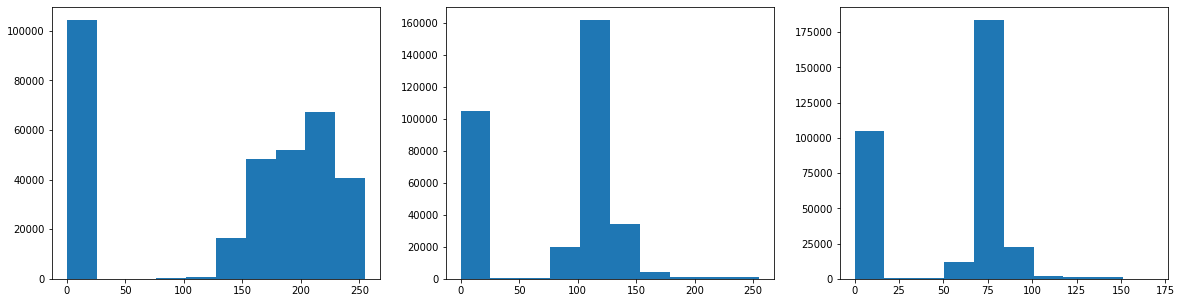

In [8]:
plt.rcParams["figure.figsize"] = (20,5)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.hist(image[:,0]);
ax1.hist(image[:,1]);
ax2.hist(image[:,2]);

In [9]:
df = pd.DataFrame(data=image, columns = ["R", "G", "B"])

In [10]:
non_retine = df[(df.R==0) & (df.G==0) & (df.B ==0)]
retine = df[~df.index.isin(list(non_retine.index))]

In [11]:
km = KMeans(n_clusters=2)

In [12]:
km.fit(retine)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
preds = km.predict(retine)

In [14]:
retine.insert(loc=retine.shape[1],column='Clustering_result', value=preds)

In [15]:
non_retine.insert(loc=non_retine.shape[1],column='Clustering_result', value=0)

In [16]:
image = pd.concat([retine,non_retine])

In [17]:
image = image.sort_index()

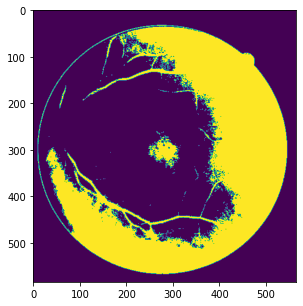

In [18]:
plt.imshow(np.array(image.Clustering_result).reshape(584, 565))

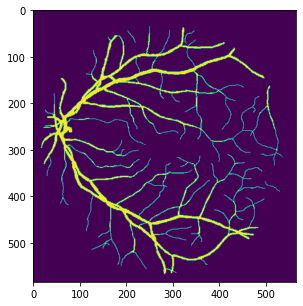

In [19]:
plt.imshow(labels['21'])

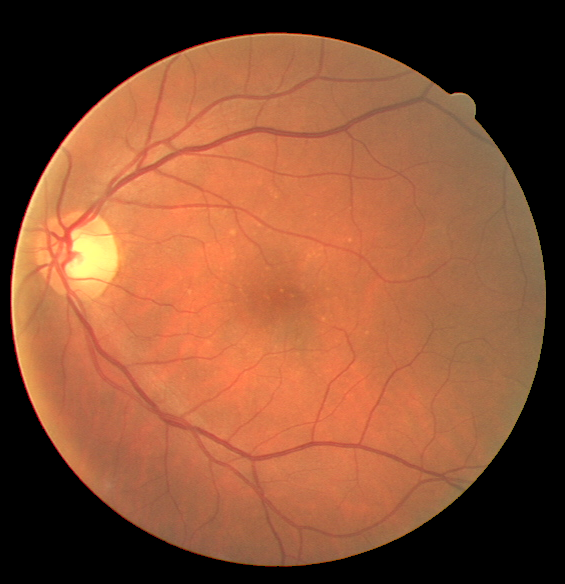

In [20]:
PIL.Image.fromarray(np.uint8(train_images['21'])).convert('RGB')

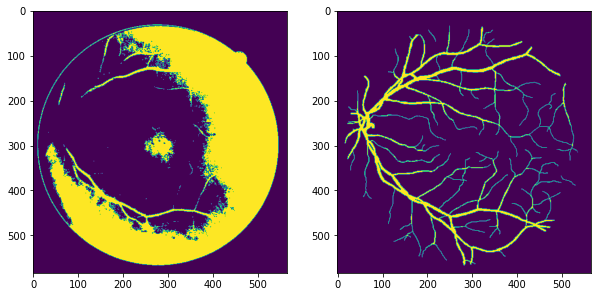

In [21]:
plt.rcParams["figure.figsize"] = (10,10)
fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(np.array(image.Clustering_result).reshape(584, 565));
ax1.imshow(labels['21']);

## Clustering sobre un solo canal

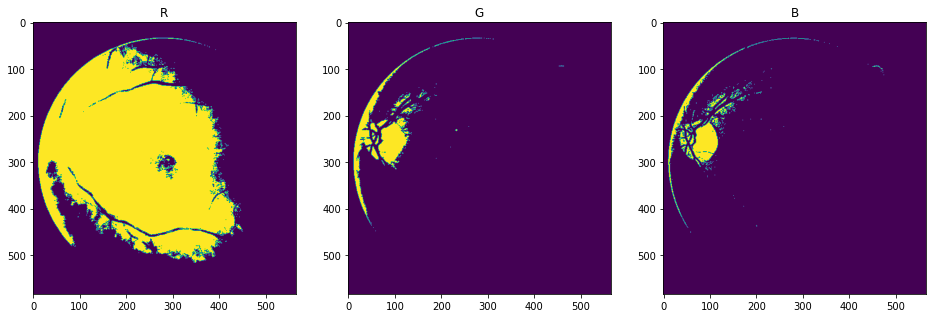

In [22]:
channel = ["R","G","B"]
plt.rcParams["figure.figsize"] = (16,5)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
for j,i in enumerate(channel):
    km = KMeans(n_clusters=2)
    non_retine = df[(df.R==0) & (df.G==0) & (df.B ==0)]
    retine = df[~df.index.isin(list(non_retine.index))]
    km.fit(retine.loc[:,i].to_numpy().reshape(-1,1))
    preds = km.predict(retine.loc[:,i].to_numpy().reshape(-1,1))
    retine.insert(loc=retine.shape[1],column='Clustering_result', value=preds)
    non_retine.insert(loc=non_retine.shape[1],column='Clustering_result', value=0)
    image = pd.concat([retine,non_retine])
    image = image.sort_index()
    eval(f'ax{j}').imshow(np.array(image.Clustering_result).reshape(584, 565))
    eval(f'ax{j}').title.set_text(i)

# DBscan

2 Clusters


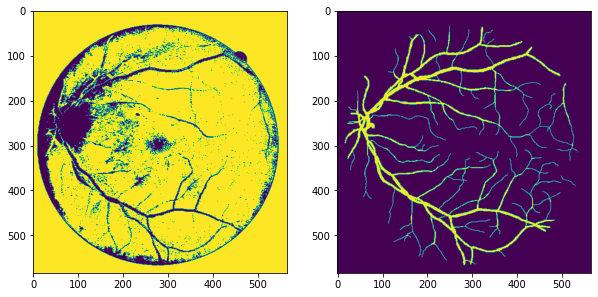

In [23]:
plt.rcParams["figure.figsize"] = (10,10)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(labels['21']);
db = DBSCAN(eps=3, min_samples=500)
non_retine = df[(df.R==0) & (df.G==0) & (df.B ==0)]
retine = df[~df.index.isin(list(non_retine.index))]
db.fit(retine.loc[:,["R","G", "B"]].to_numpy())
preds = db.labels_
retine.insert(loc=retine.shape[1],column='Clustering_result', value=preds)
non_retine.insert(loc=non_retine.shape[1],column='Clustering_result', value=0)
image = pd.concat([retine,non_retine])
image = image.sort_index()
ax0.imshow(np.array(image.Clustering_result).reshape(584, 565))
print(f'{len(np.unique(preds))} Clusters')

2 Clusters


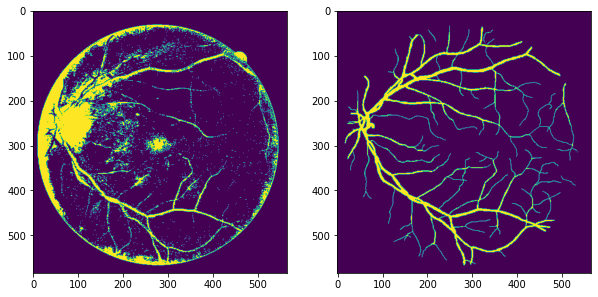

In [61]:
inverted = np.array(image.Clustering_result).reshape(584, 565)*-1
plt.rcParams["figure.figsize"] = (10,10)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(labels['21']);
ax0.imshow(inverted)
print(f'{len(np.unique(preds))} Clusters')

In [62]:
print(f' ACC: {accuracy_score(labels["21"].reshape(-1),inverted.reshape(-1))}')
print(f' AUC: {roc_auc_score(labels["21"].reshape(-1),inverted.reshape(-1))}')

 ACC: 0.8257122075403079
 AUC: 0.7057920187218873


## Quickshift

Number of segments: 4


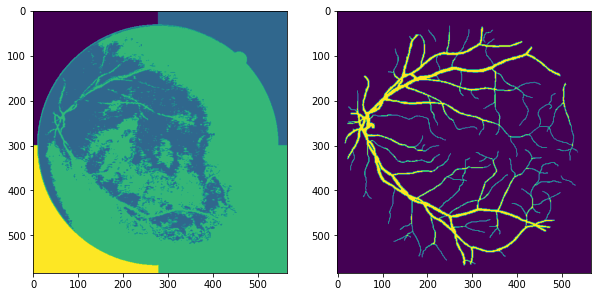

In [24]:
plt.rcParams["figure.figsize"] = (10,10)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(labels['21']);
fe = segmentation.quickshift(df.to_numpy().reshape(584,565,3), max_dist=1e24, kernel_size=49)
ax0.imshow(fe)
print("Number of segments: {}".format(len(np.unique(fe))))

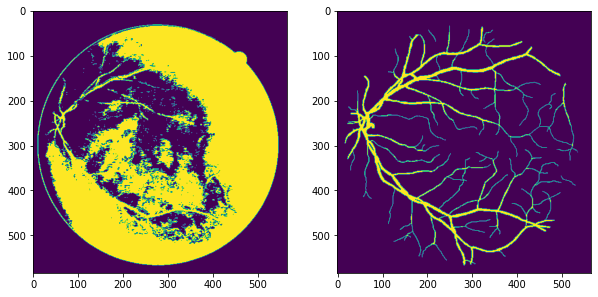

In [25]:
img =  fe * masks['21'][:,:,0]/255
img = img - 1
img[img<0] = 0
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(labels['21']);
ax0.imshow(img)

### Thresholding

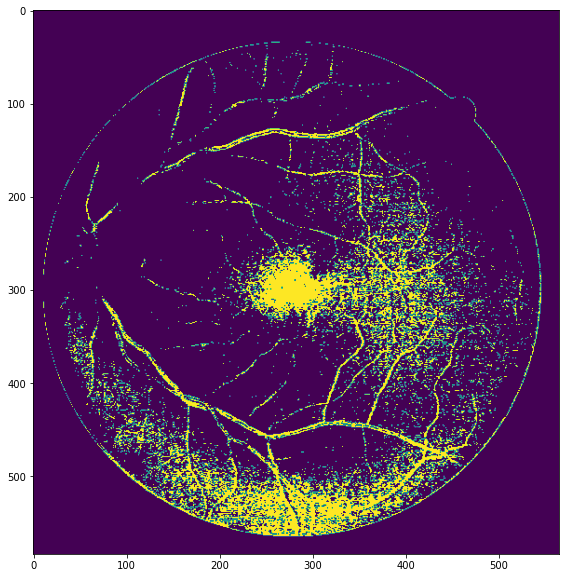

In [26]:
plt.imshow(((df.B > 40) & (df.B < 71)).to_numpy().reshape(584, 565))

In [53]:
print(f' ACC: {accuracy_score(labels["21"].reshape(-1),((df.B > 40) & (df.B < 71)).to_numpy())}')
print(f' AUC: {roc_auc_score(labels["21"].reshape(-1),((df.B > 40) & (df.B < 71)).to_numpy())}')

 ACC: 0.8442265729179295
 AUC: 0.6378302835274917


### SVM

In [27]:
from sklearn.svm import SVC

In [28]:
svc = SVC()

In [29]:
np.random.seed(1)
sample = np.random.randint(22,40,2).astype('str')
X = []
y = []
for i in sample:
    X.append(train_images[i].reshape(-1,3))
    y.append(labels[i].reshape(-1))

In [30]:
X = pd.DataFrame(np.concatenate(X))
y = pd.DataFrame(np.concatenate(y))

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
x = sc.transform(X)

In [33]:
svc.fit(x, y)

/Users/alberto/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
X_test = train_images['21'].reshape(-1,3)
y_test = labels['21'].reshape(-1)

In [36]:
x_test = sc.transform(X_test)

In [40]:
preds = svc.predict(x_test)

In [49]:
#On test
print(f' ACC: {accuracy_score(y_test, preds)}')
print(f' AUC: {roc_auc_score(y_test, preds)}')

 ACC: 0.8679264153230695
 AUC: 0.7397538871954781


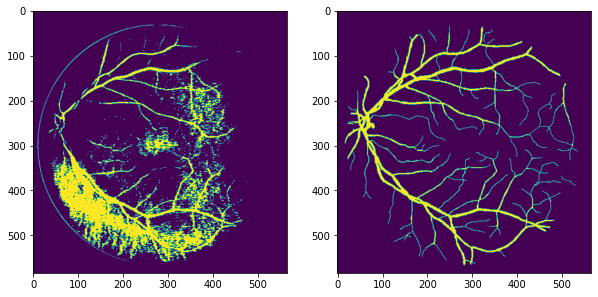

In [43]:
plt.rcParams["figure.figsize"] = (10,10)
fig, (ax0, ax1) = plt.subplots(1, 2)
ax1.imshow(labels['21']);
ax0.imshow(preds.reshape(584, 565))